# import libraries

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 42
rng = RandomState(seed)

df = pd.read_csv('Model.csv')

X, y = df.iloc[:, 1:-1], df.iloc[:, -1]
print(X.shape, y.shape)

(12529, 59) (12529,)


In [2]:
df.head()

,Unnamed: 0,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,...,income,education,age,time,expiration,driving_distance,gender,has_children,direction_opp,Y
0,0,0,1,0,1,0,0,0,0,0,...,3,2,1,1,1,0,0,1,1,1
1,1,0,1,0,0,1,0,0,0,0,...,3,2,1,0,0,0,0,1,1,0
2,2,0,1,0,0,1,0,0,0,0,...,3,2,1,0,0,1,0,1,1,1
3,3,0,1,0,0,1,0,0,0,0,...,3,2,1,1,0,1,0,1,1,0
4,4,0,1,0,0,1,0,0,0,0,...,3,2,1,1,1,1,0,1,1,0


# train-test split

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=seed)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (10023, 59) (10023,)
Test set:  (2506, 59) (2506,)


In [6]:
# Grow a full tree to get maximum depth 
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None,
                              random_state=seed)
tree.fit(X_train, y_train)
print('Depth: ', tree.get_depth())

Depth:  34


# cross val score using roc-auc

In [10]:
def cross_validation_score(estimator):
    scores = cross_val_score(
        estimator, X_train, y_train, cv=10, n_jobs=-1,
        scoring='roc_auc'
    )
    
    return scores.mean(), scores.std()


def plot_cross_validation(title, X, Y, error, xlabel, ylabel='ROC AUC'):
    plt.title(title)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

# Change max_depth, criterion=entropy

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.74s/it]


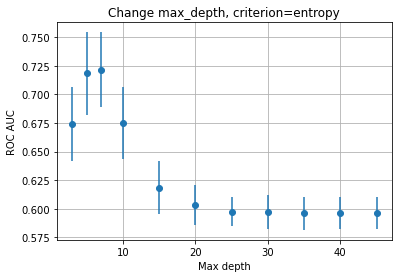

In [11]:
title = 'Change max_depth, criterion=entropy'
xlabel = 'Max depth'
max_depths = [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45]
means = []
stddevs = []

for n in tqdm(max_depths):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=n, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)

plot_cross_validation(title, max_depths, means, stddevs, xlabel)
plt.savefig('DT_entropy_change_depth.png', bbox_inches='tight')
plt.show()

# Change max_depth, criterion=gini

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.44it/s]


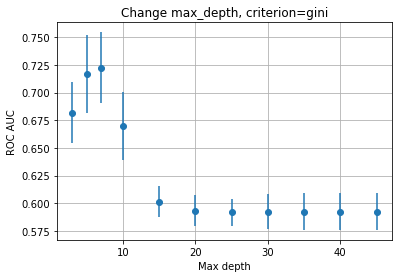

In [12]:
title = 'Change max_depth, criterion=gini'
xlabel = 'Max depth'
max_depths = [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45]
means = []
stddevs = []

for n in tqdm(max_depths):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=n, 
                                 random_state=rng)
    mean, std = cross_validation_score(clf)
    means.append(mean)
    stddevs.append(std)

plot_cross_validation(title, max_depths, means, stddevs, xlabel)
plt.savefig('DT_gini_change_depth.png', bbox_inches='tight')
plt.show()

# ROC-AUC

In [7]:
# Best params
from sklearn.metrics import roc_auc_score, accuracy_score

tree = DecisionTreeClassifier(criterion='entropy', max_depth=7, 
                              random_state=rng)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('ROC AUC on test set: ', roc_auc_score(y_test, y_pred))

Accuracy on test set:  0.6983240223463687
ROC AUC on test set:  0.6936137857845421


In [9]:
#feature_importances = tree.feature_importances_

#k = 10
#topk = feature_importances.argsort()

#for i in topk:
    #print('%-30s: %.6f' % (X.columns[i], feature_importances[i]))

# Feature importance for decision tree

In [10]:
feature_importances = tree.feature_importances_

k = 10
topk = feature_importances.argsort()[-k:][::-1]  #taking last 10 rows and among them sorted by descending order

for i in topk:
    print('%-30s: %.6f' % (X.columns[i], feature_importances[i]))

coupon_Restaurant(<20)        : 0.199249
coupon_Carry out & Take away  : 0.148621
CoffeeHouse                   : 0.143513
driving_distance              : 0.101344
expiration                    : 0.096575
coupon_Coffee House           : 0.088707
Bar                           : 0.078694
time                          : 0.023662
destination_No Urgent Place   : 0.018722
income                        : 0.017290


# Confusion Matrix

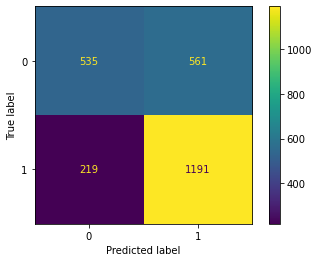

In [12]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(tree, X_test, y_test)
plt.savefig('DT_confmat.png')

In [13]:
from sklearn.tree import export_text

text = export_text(tree, feature_names=list(X.columns))
print(text)

|--- coupon_Carry out & Take away <= 0.50
|   |--- coupon_Restaurant(<20) <= 0.50
|   |   |--- CoffeeHouse <= 0.50
|   |   |   |--- coupon_Coffee House <= 0.50
|   |   |   |   |--- Bar <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Bar >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- coupon_Coffee House >  0.50
|   |   |   |   |--- income <= 4.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- income >  4.50
|   |   |   |   |   |--- class: 0
|   |   |--- CoffeeHouse >  0.50
|   |   |   |--- coupon_Coffee House <= 0.50
|   |   |   |   |--- Bar <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Bar >  1.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- coupon_Coffee House >  0.50
|   |   |   |   |--- expiration <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- expiration >  0.50
|   |   |   |   |   |--- class: 1
|   |--- coupon_Restaurant(<20) >  0.50
|   |   |--- driving_distance <= 1.50
|   |   |   |--- expiration <= 0.50
| 

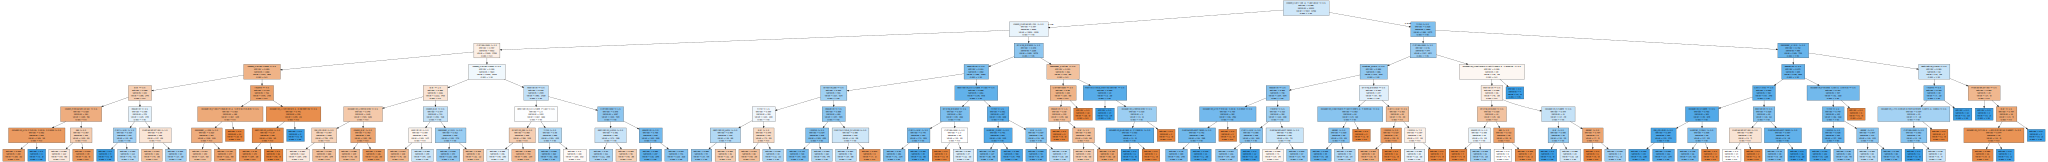

In [8]:
from sklearn.tree import plot_tree, export_graphviz
import graphviz

dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=list(X.columns),
                           class_names=['No', 'Yes'],
                           filled=True)

graph = graphviz.Source(dot_data, format='png')
graph